# 06 - Machine Learning Models for Volume Forecasting

This notebook demonstrates ML-based forecasting models using gradient boosting algorithms:

1. **XGBoost**: Extreme Gradient Boosting - highly efficient and widely used
2. **LightGBM**: Light Gradient Boosting Machine - fast and memory-efficient

Both models use the `FeaturePipeline` to create temporal, lag, and rolling features from the raw time series data.

## Why Tree-Based Models for Time Series?

- **Non-linear patterns**: Can capture complex interactions between features
- **No assumptions**: Unlike ARIMA, no stationarity requirements
- **Feature importance**: Built-in interpretability through feature importance scores
- **Robust**: Handle outliers and missing values well

## Notebook Structure

1. Setup and imports
2. Load synthetic volume data
3. Feature engineering with FeaturePipeline
4. Train/validation split
5. XGBoost model training and evaluation
6. LightGBM model training and evaluation
7. Feature importance visualization
8. Comparison with baseline models
9. Summary and discussion

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path
from datetime import date

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add src to path for imports
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

# Import feature engineering pipeline
from volume_forecast.features import FeaturePipeline

# Import ML models
from volume_forecast.models import XGBoostModel

# Try to import LightGBM (may not be available on all systems)
try:
    from volume_forecast.models import LightGBMModel
    LIGHTGBM_AVAILABLE = True
    print("LightGBM is available.")
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM is not installed. Skipping LightGBM sections.")

# Import baseline models for comparison
from volume_forecast.models import NaiveModel, SeasonalNaiveModel, MovingAverageModel

# Import evaluation metrics
from volume_forecast.evaluation import mae, rmse, mape

# Import data generator (in case we need to create data)
from volume_forecast.data_generation import VolumeGenerator

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("\nSetup complete!")

LightGBM is available.

Setup complete!


## 2. Load Synthetic Volume Data

We load the synthetic volume data generated in notebook 01. If the file does not exist, we generate it using the `VolumeGenerator`.

In [2]:
# Define data path
data_path = project_root / "data" / "raw" / "synthetic_volumes.csv"

# Load or generate data
if data_path.exists():
    df = pd.read_csv(data_path, parse_dates=["date"])
    print(f"Loaded data from {data_path}")
else:
    print(f"Data file not found at {data_path}. Generating synthetic data...")
    generator = VolumeGenerator(seed=42)
    df = generator.generate(
        start_date=date(2023, 1, 1),
        end_date=date(2024, 12, 31),
        include_events=True
    )
    # Save for future use
    data_path.parent.mkdir(parents=True, exist_ok=True)
    generator.save(df, data_path)
    print(f"Generated and saved data to {data_path}")

# Display basic info
print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {len(df)}")
df.head()

Loaded data from c:\Users\juanlu\dev\volume-forecasting-poc\data\raw\synthetic_volumes.csv

Dataset shape: (731, 4)
Date range: 2023-01-01 00:00:00 to 2024-12-31 00:00:00
Total days: 731


,date,daily_logins,daily_deposits,daily_deposit_volume_gbp
0,2023-01-01,59273,9648,267406
1,2023-01-02,39425,7242,234617
2,2023-01-03,45752,6452,234713
3,2023-01-04,49327,7341,224131
4,2023-01-05,37494,7282,204090


## 3. Feature Engineering with FeaturePipeline

We use the `FeaturePipeline` to create:
- **Temporal features**: day_of_week, month, is_weekend, cyclical encodings (sin/cos)
- **Lag features**: Previous values at lags 1, 7, 14, 21 days
- **Rolling features**: Moving averages and standard deviations (7, 14, 30 day windows)

In [3]:
# Sort by date to ensure chronological order
df = df.sort_values('date').reset_index(drop=True)

# Initialize the feature pipeline
pipeline = FeaturePipeline(
    date_column='date',
    target_columns=['daily_logins', 'daily_deposits'],
    lags=[1, 7, 14, 21],
    rolling_windows=[7, 14, 30],
    rolling_stats=['mean', 'std'],
    cyclical=True
)

# Display pipeline configuration
print("Pipeline Parameters:")
for key, value in pipeline.get_params().items():
    print(f"  {key}: {value}")

Pipeline Parameters:
  date_column: date
  target_columns: ['daily_logins', 'daily_deposits']
  lags: [1, 7, 14, 21]
  rolling_windows: [7, 14, 30]
  rolling_stats: ['mean', 'std']
  cyclical: True
  include_events: False
  include_football: True
  events_cache_dir: None


In [4]:
# Fit and transform
pipeline.fit(df)
df_features = pipeline.transform(df)

print(f"Original columns: {len(df.columns)}")
print(f"After feature engineering: {len(df_features.columns)}")
print(f"New features added: {len(df_features.columns) - len(df.columns)}")

# Get feature names from pipeline
feature_names = pipeline.get_feature_names()
print(f"\nTotal features generated: {len(feature_names)}")

Original columns: 4
After feature engineering: 38
New features added: 34

Total features generated: 34


In [5]:
# Preview the feature-engineered data
df_features.head(10)

,date,daily_logins,daily_deposits,daily_deposit_volume_gbp,day_of_week,day_of_month,month,week_of_year,is_weekend,is_month_start,is_month_end,days_to_payday,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_sin,week_cos,daily_logins_lag_1,daily_logins_lag_7,daily_logins_lag_14,daily_logins_lag_21,daily_deposits_lag_1,daily_deposits_lag_7,daily_deposits_lag_14,daily_deposits_lag_21,daily_logins_rolling_mean_7,daily_logins_rolling_std_7,daily_logins_rolling_mean_14,daily_logins_rolling_std_14,daily_logins_rolling_mean_30,daily_logins_rolling_std_30,daily_deposits_rolling_mean_7,daily_deposits_rolling_std_7,daily_deposits_rolling_mean_14,daily_deposits_rolling_std_14,daily_deposits_rolling_mean_30,daily_deposits_rolling_std_30
0,2023-01-01,59273,9648,267406,6,1,1,52,1,1,0,14,-0.78,0.62,0.50,0.87,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59273.00,NaN,59273.00,NaN,59273.00,NaN,9648.00,NaN,9648.00,NaN,9648.00,NaN
1,2023-01-02,39425,7242,234617,0,2,1,1,0,0,0,13,0.00,1.00,0.50,0.87,0.12,0.99,59273.00,NaN,NaN,NaN,9648.00,NaN,NaN,NaN,49349.00,14034.66,49349.00,14034.66,49349.00,14034.66,8445.00,1701.30,8445.00,1701.30,8445.00,1701.30
2,2023-01-03,45752,6452,234713,1,3,1,1,0,0,0,12,0.78,0.62,0.50,0.87,0.12,0.99,39425.00,NaN,NaN,NaN,7242.00,NaN,NaN,NaN,48150.00,10138.96,48150.00,10138.96,48150.00,10138.96,7780.67,1664.70,7780.67,1664.70,7780.67,1664.70
3,2023-01-04,49327,7341,224131,2,4,1,1,0,0,0,11,0.97,-0.22,0.50,0.87,0.12,0.99,45752.00,NaN,NaN,NaN,6452.00,NaN,NaN,NaN,48444.25,8299.32,48444.25,8299.32,48444.25,8299.32,7670.75,1376.88,7670.75,1376.88,7670.75,1376.88
4,2023-01-05,37494,7282,204090,3,5,1,1,0,0,0,10,0.43,-0.90,0.50,0.87,0.12,0.99,49327.00,NaN,NaN,NaN,7341.00,NaN,NaN,NaN,46254.20,8697.16,46254.20,8697.16,46254.20,8697.16,7593.00,1205.02,7593.00,1205.02,7593.00,1205.02
5,2023-01-06,45989,8870,228493,4,6,1,1,0,0,0,9,-0.43,-0.90,0.50,0.87,0.12,0.99,37494.00,NaN,NaN,NaN,7282.00,NaN,NaN,NaN,46210.00,7779.73,46210.00,7779.73,46210.00,7779.73,7805.83,1197.27,7805.83,1197.27,7805.83,1197.27
6,2023-01-07,68889,12483,305571,5,7,1,1,1,0,0,8,-0.97,-0.22,0.50,0.87,0.12,0.99,45989.00,NaN,NaN,NaN,8870.00,NaN,NaN,NaN,49449.86,11131.65,49449.86,11131.65,49449.86,11131.65,8474.00,2078.38,8474.00,2078.38,8474.00,2078.38
7,2023-01-08,56168,8149,244559,6,8,1,1,1,0,0,7,-0.78,0.62,0.50,0.87,0.12,0.99,68889.00,59273.00,NaN,NaN,12483.00,9648.00,NaN,NaN,49006.29,10729.58,50289.62,10576.07,50289.62,10576.07,8259.86,2013.47,8433.38,1927.64,8433.38,1927.64
8,2023-01-09,44540,5219,225862,0,9,1,2,0,0,0,6,0.00,1.00,0.50,0.87,0.24,0.97,56168.00,39425.00,NaN,NaN,8149.00,7242.00,NaN,NaN,49737.00,10125.48,49650.78,10076.94,49650.78,10076.94,7970.86,2307.61,8076.22,2097.46,8076.22,2097.46
9,2023-01-10,37734,7133,238126,1,10,1,2,0,0,0,5,0.78,0.62,0.50,0.87,0.24,0.97,44540.00,45752.00,NaN,NaN,5219.00,6452.00,NaN,NaN,48591.57,11061.65,48459.10,10220.71,48459.10,10220.71,8068.14,2246.45,7981.90,1999.87,7981.90,1999.87


## 4. Train/Validation Split

We split the data chronologically:
- **Training**: First 365 days (captures full yearly seasonality)
- **Validation**: Remaining days

We also drop rows with NaN values resulting from lag/rolling feature creation.

In [6]:
# Define constants
INITIAL_TRAIN_DAYS = 365
FORECAST_HORIZON = 7
TARGET = 'daily_logins'  # Primary target for forecasting

# Identify feature columns (exclude date and target columns)
exclude_cols = ['date', 'daily_logins', 'daily_deposits']
feature_cols = [col for col in df_features.columns if col not in exclude_cols]

print(f"Number of feature columns: {len(feature_cols)}")
print(f"\nFeature columns:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2}. {col}")

Number of feature columns: 35

Feature columns:
   1. daily_deposit_volume_gbp
   2. day_of_week
   3. day_of_month
   4. month
   5. week_of_year
   6. is_weekend
   7. is_month_start
   8. is_month_end
   9. days_to_payday
  10. day_of_week_sin
  11. day_of_week_cos
  12. month_sin
  13. month_cos
  14. week_sin
  15. week_cos
  16. daily_logins_lag_1
  17. daily_logins_lag_7
  18. daily_logins_lag_14
  19. daily_logins_lag_21
  20. daily_deposits_lag_1
  21. daily_deposits_lag_7
  22. daily_deposits_lag_14
  23. daily_deposits_lag_21
  24. daily_logins_rolling_mean_7
  25. daily_logins_rolling_std_7
  26. daily_logins_rolling_mean_14
  27. daily_logins_rolling_std_14
  28. daily_logins_rolling_mean_30
  29. daily_logins_rolling_std_30
  30. daily_deposits_rolling_mean_7
  31. daily_deposits_rolling_std_7
  32. daily_deposits_rolling_mean_14
  33. daily_deposits_rolling_std_14
  34. daily_deposits_rolling_mean_30
  35. daily_deposits_rolling_std_30


In [7]:
# Drop rows with NaN values (from lag/rolling features)
df_clean = df_features.dropna(subset=feature_cols).copy()
print(f"Rows before dropping NaN: {len(df_features)}")
print(f"Rows after dropping NaN: {len(df_clean)}")
print(f"Rows dropped: {len(df_features) - len(df_clean)}")

# Reset index after dropping
df_clean = df_clean.reset_index(drop=True)

Rows before dropping NaN: 731
Rows after dropping NaN: 710
Rows dropped: 21


In [8]:
# Split data
# Find the split index (365 days from the start of clean data)
train_end_date = df_clean['date'].iloc[0] + pd.Timedelta(days=INITIAL_TRAIN_DAYS - 1)
split_idx = df_clean[df_clean['date'] <= train_end_date].index[-1] + 1

train_df = df_clean.iloc[:split_idx].copy()
valid_df = df_clean.iloc[split_idx:].copy()

print(f"Training set: {len(train_df)} days ({train_df['date'].min().date()} to {train_df['date'].max().date()})")
print(f"Validation set: {len(valid_df)} days ({valid_df['date'].min().date()} to {valid_df['date'].max().date()})")

Training set: 365 days (2023-01-22 to 2024-01-21)
Validation set: 345 days (2024-01-22 to 2024-12-31)


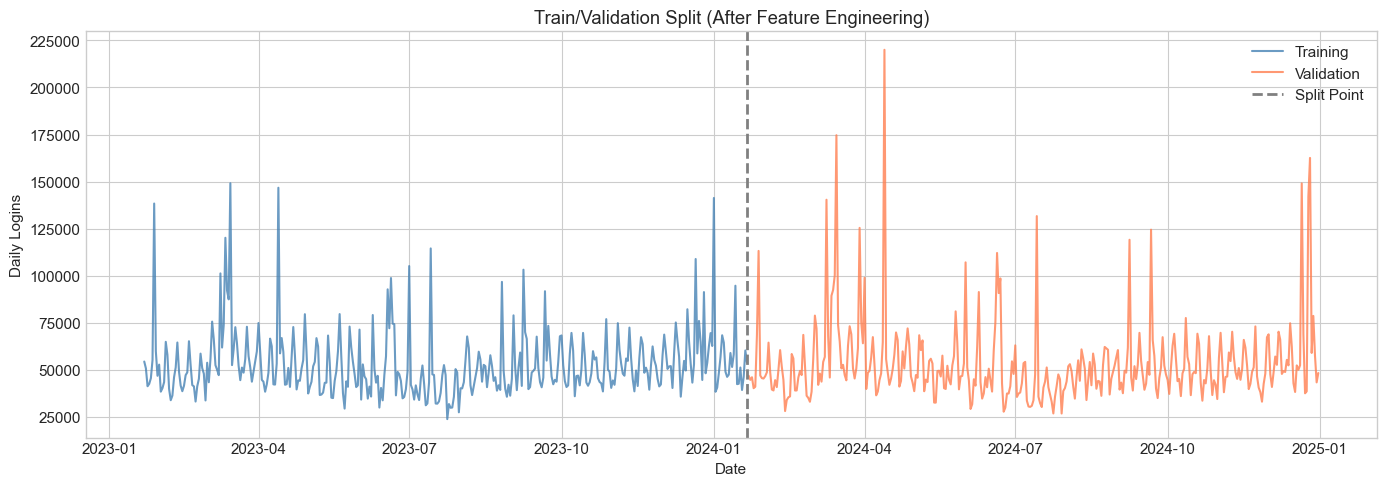

In [9]:
# Visualize the split
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(train_df['date'], train_df[TARGET], label='Training', color='steelblue', alpha=0.8)
ax.plot(valid_df['date'], valid_df[TARGET], label='Validation', color='coral', alpha=0.8)

# Add vertical line at split point
ax.axvline(x=train_df['date'].iloc[-1], color='gray', linestyle='--', linewidth=2, label='Split Point')

ax.set_xlabel('Date')
ax.set_ylabel('Daily Logins')
ax.set_title('Train/Validation Split (After Feature Engineering)')
ax.legend()
plt.tight_layout()
plt.show()

## 5. XGBoost Model

XGBoost (Extreme Gradient Boosting) is a powerful ensemble learning algorithm that builds decision trees sequentially, with each tree correcting the errors of the previous ones.

### Key Hyperparameters
- `n_estimators`: Number of boosting rounds (trees)
- `max_depth`: Maximum depth of each tree
- `learning_rate`: Step size shrinkage to prevent overfitting

In [10]:
# Initialize XGBoost model
xgb_model = XGBoostModel(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    name='xgboost'
)

print("XGBoost Model Parameters:")
for key, value in xgb_model.get_params().items():
    print(f"  {key}: {value}")

XGBoost Model Parameters:
  name: xgboost
  n_estimators: 100
  max_depth: 6
  learning_rate: 0.1
  lags: [1, 7, 14]
  external_features: []


In [11]:
# Fit XGBoost model on training data
# Note: We let the model use its own lag features for recursive forecasting
# This ensures consistency between training and prediction
xgb_model.fit(train_df, target=TARGET)
print("XGBoost model fitted successfully!")
print(f"Using internal lag features: {xgb_model.lags}")

XGBoost model fitted successfully!
Using internal lag features: [1, 7, 14]


In [12]:
# Generate predictions for 7-day horizon
xgb_predictions = xgb_model.predict(valid_df, horizon=FORECAST_HORIZON)

# Get actual values for comparison
xgb_actuals = valid_df[TARGET].iloc[:FORECAST_HORIZON].values
xgb_preds = xgb_predictions['prediction'].values

# Calculate metrics
xgb_mae = mae(xgb_actuals, xgb_preds)
xgb_rmse = rmse(xgb_actuals, xgb_preds)
xgb_mape = mape(xgb_actuals, xgb_preds)

print("XGBoost Model Results (7-day forecast):")
print(f"  MAE:  {xgb_mae:.2f}")
print(f"  RMSE: {xgb_rmse:.2f}")
print(f"  MAPE: {xgb_mape:.2f}%")

XGBoost Model Results (7-day forecast):
  MAE:  26572.68
  RMSE: 33867.44
  MAPE: 45.96%


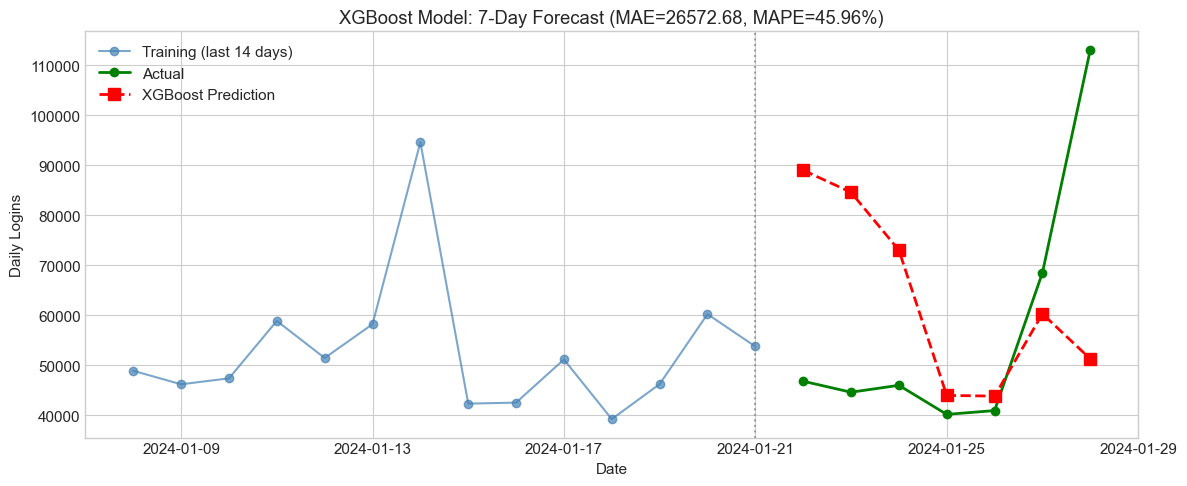

In [13]:
# Plot XGBoost predictions
fig, ax = plt.subplots(figsize=(12, 5))

# Plot last 14 days of training + 7 days forecast
context_days = 14
ax.plot(train_df['date'].iloc[-context_days:], train_df[TARGET].iloc[-context_days:], 
        'o-', color='steelblue', label='Training (last 14 days)', alpha=0.7)
ax.plot(valid_df['date'].iloc[:FORECAST_HORIZON], xgb_actuals, 
        'o-', color='green', label='Actual', linewidth=2)
ax.plot(xgb_predictions['date'], xgb_preds, 
        's--', color='red', label='XGBoost Prediction', linewidth=2, markersize=8)

ax.axvline(x=train_df['date'].iloc[-1], color='gray', linestyle=':', alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Logins')
ax.set_title(f'XGBoost Model: 7-Day Forecast (MAE={xgb_mae:.2f}, MAPE={xgb_mape:.2f}%)')
ax.legend()
plt.tight_layout()
plt.show()

## 6. LightGBM Model

LightGBM is another gradient boosting framework that uses histogram-based algorithms for faster training and lower memory usage.

**Note**: LightGBM may have compatibility issues on some Windows systems. This section is wrapped in a try/except block to handle cases where LightGBM is not available.

In [14]:
# LightGBM Model Training and Evaluation
lgb_results = None

if LIGHTGBM_AVAILABLE:
    try:
        # Initialize LightGBM model
        lgb_model = LightGBMModel(
            n_estimators=100,
            max_depth=-1,  # -1 means unlimited
            learning_rate=0.1,
            name='lightgbm'
        )
        
        print("LightGBM Model Parameters:")
        for key, value in lgb_model.get_params().items():
            print(f"  {key}: {value}")
        
        # Fit LightGBM model using its internal lag features
        lgb_model.fit(train_df, target=TARGET)
        print("\nLightGBM model fitted successfully!")
        print(f"Using internal lag features: {lgb_model.lags}")
        
        # Generate predictions
        lgb_predictions = lgb_model.predict(valid_df, horizon=FORECAST_HORIZON)
        
        # Get actual values for comparison
        lgb_actuals = valid_df[TARGET].iloc[:FORECAST_HORIZON].values
        lgb_preds = lgb_predictions['prediction'].values
        
        # Calculate metrics
        lgb_mae = mae(lgb_actuals, lgb_preds)
        lgb_rmse = rmse(lgb_actuals, lgb_preds)
        lgb_mape = mape(lgb_actuals, lgb_preds)
        
        print("\nLightGBM Model Results (7-day forecast):")
        print(f"  MAE:  {lgb_mae:.2f}")
        print(f"  RMSE: {lgb_rmse:.2f}")
        print(f"  MAPE: {lgb_mape:.2f}%")
        
        # Store results for comparison
        lgb_results = {
            'model': lgb_model,
            'predictions': lgb_predictions,
            'actuals': lgb_actuals,
            'preds': lgb_preds,
            'mae': lgb_mae,
            'rmse': lgb_rmse,
            'mape': lgb_mape
        }
        
    except Exception as e:
        print(f"Error training LightGBM model: {e}")
        print("Continuing without LightGBM...")
        LIGHTGBM_AVAILABLE = False
else:
    print("LightGBM is not available. Skipping this section.")
    print("To install LightGBM, run: pip install lightgbm")

LightGBM Model Parameters:
  name: lightgbm
  n_estimators: 100
  max_depth: -1
  learning_rate: 0.1
  lags: [1, 7, 14]
  external_features: []

LightGBM model fitted successfully!
Using internal lag features: [1, 7, 14]

LightGBM Model Results (7-day forecast):
  MAE:  22469.62
  RMSE: 28440.44
  MAPE: 38.15%


c:\Users\juanlu\dev\volume-forecasting-poc\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\juanlu\dev\volume-forecasting-poc\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\juanlu\dev\volume-forecasting-poc\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\juanlu\dev\volume-forecasting-poc\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\juanlu\dev\volume-forecasting-poc\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid 

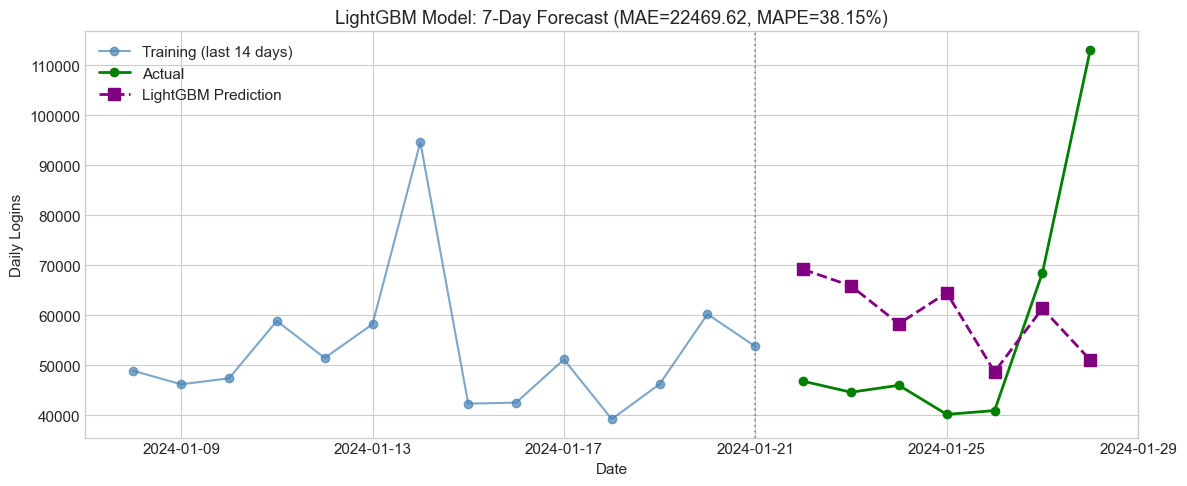

In [15]:
# Plot LightGBM predictions (if available)
if lgb_results is not None:
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ax.plot(train_df['date'].iloc[-context_days:], train_df[TARGET].iloc[-context_days:], 
            'o-', color='steelblue', label='Training (last 14 days)', alpha=0.7)
    ax.plot(valid_df['date'].iloc[:FORECAST_HORIZON], lgb_results['actuals'], 
            'o-', color='green', label='Actual', linewidth=2)
    ax.plot(lgb_results['predictions']['date'], lgb_results['preds'], 
            's--', color='purple', label='LightGBM Prediction', linewidth=2, markersize=8)
    
    ax.axvline(x=train_df['date'].iloc[-1], color='gray', linestyle=':', alpha=0.7)
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily Logins')
    ax.set_title(f'LightGBM Model: 7-Day Forecast (MAE={lgb_results["mae"]:.2f}, MAPE={lgb_results["mape"]:.2f}%)')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("LightGBM results not available for plotting.")

## 7. Feature Importance Visualization

One of the key advantages of tree-based models is their built-in feature importance. This helps us understand which features are most predictive.

In [16]:
# Get XGBoost feature importance
xgb_importance = xgb_model._model.feature_importances_

# The model uses internal lag features
lag_feature_names = [f"lag_{lag}" for lag in xgb_model.lags]

# Create DataFrame for visualization
xgb_importance_df = pd.DataFrame({
    'feature': lag_feature_names,
    'importance': xgb_importance
}).sort_values('importance', ascending=False)

print("Features by XGBoost Importance:")
print("=" * 50)
for i, row in xgb_importance_df.iterrows():
    print(f"{row['feature']:40} {row['importance']:.4f}")

Features by XGBoost Importance:
lag_7                                    0.3798
lag_14                                   0.3493
lag_1                                    0.2708


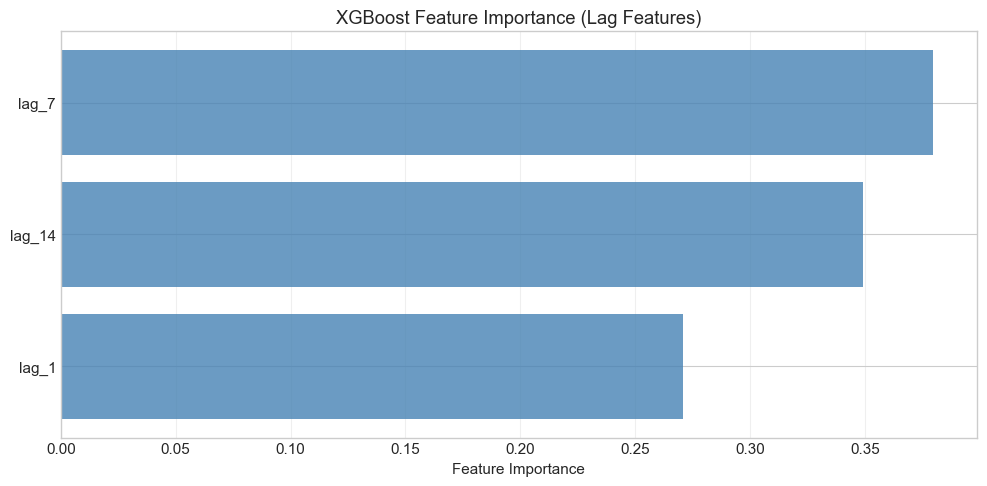

In [17]:
# Plot XGBoost feature importance
fig, ax = plt.subplots(figsize=(10, 5))

n_features = len(xgb_importance_df)

bars = ax.barh(range(n_features), xgb_importance_df['importance'].values, color='steelblue', alpha=0.8)
ax.set_yticks(range(n_features))
ax.set_yticklabels(xgb_importance_df['feature'].values)
ax.invert_yaxis()  # Highest importance at top
ax.set_xlabel('Feature Importance')
ax.set_title('XGBoost Feature Importance (Lag Features)')
ax.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

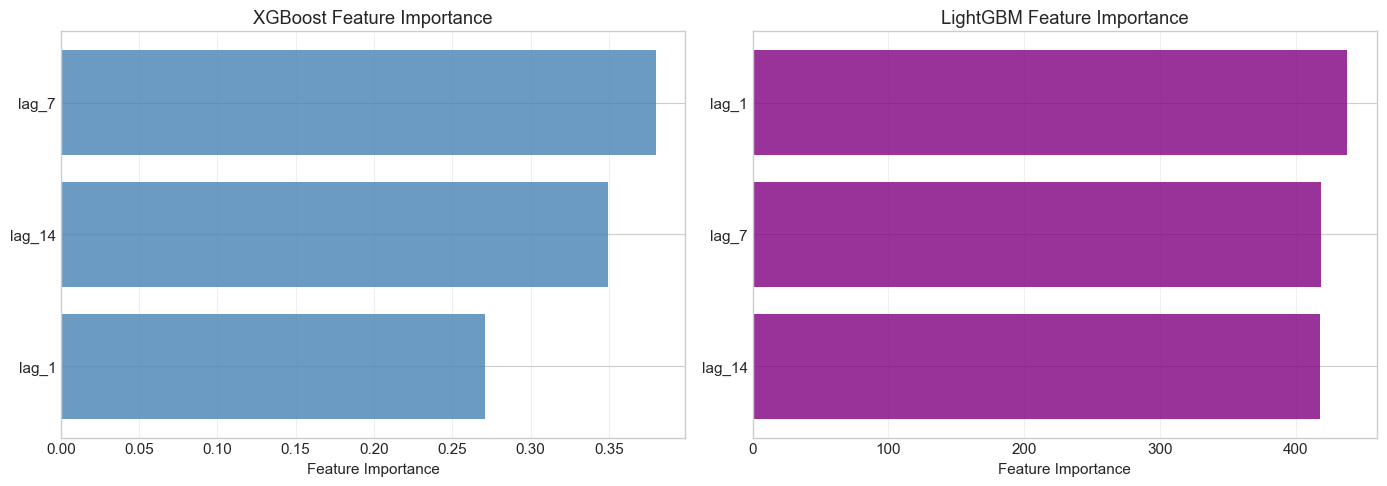


Feature Importance Comparison:
XGBoost                   LightGBM                 
--------------------------------------------------
1. lag_7                  lag_1                 
2. lag_14                 lag_7                 
3. lag_1                  lag_14                


In [18]:
# Compare feature importance between XGBoost and LightGBM (if available)
if lgb_results is not None:
    lgb_importance = lgb_results['model']._model.feature_importances_
    lgb_lag_features = [f"lag_{lag}" for lag in lgb_results['model'].lags]
    
    lgb_importance_df = pd.DataFrame({
        'feature': lgb_lag_features,
        'importance': lgb_importance
    }).sort_values('importance', ascending=False)
    
    # Create side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # XGBoost
    ax = axes[0]
    n_xgb = len(xgb_importance_df)
    ax.barh(range(n_xgb), xgb_importance_df['importance'].values, color='steelblue', alpha=0.8)
    ax.set_yticks(range(n_xgb))
    ax.set_yticklabels(xgb_importance_df['feature'].values)
    ax.invert_yaxis()
    ax.set_xlabel('Feature Importance')
    ax.set_title('XGBoost Feature Importance')
    ax.grid(True, axis='x', alpha=0.3)
    
    # LightGBM
    ax = axes[1]
    n_lgb = len(lgb_importance_df)
    ax.barh(range(n_lgb), lgb_importance_df['importance'].values, color='purple', alpha=0.8)
    ax.set_yticks(range(n_lgb))
    ax.set_yticklabels(lgb_importance_df['feature'].values)
    ax.invert_yaxis()
    ax.set_xlabel('Feature Importance')
    ax.set_title('LightGBM Feature Importance')
    ax.grid(True, axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nFeature Importance Comparison:")
    print("=" * 50)
    print(f"{'XGBoost':25} {'LightGBM':25}")
    print("-" * 50)
    for i in range(min(len(xgb_importance_df), len(lgb_importance_df))):
        xgb_feat = xgb_importance_df.iloc[i]['feature']
        lgb_feat = lgb_importance_df.iloc[i]['feature']
        print(f"{i+1}. {xgb_feat:22} {lgb_feat:22}")
else:
    print("LightGBM not available for feature importance comparison.")

## 8. Comparison with Baseline and Statistical Models

Let's compare the ML models with baseline models to see how much improvement they provide.

In [19]:
# Helper function for baseline model evaluation
def evaluate_baseline_model(model, train_data, test_data, target, horizon=7):
    """
    Fit baseline model and calculate metrics on test data.
    """
    # Fit model
    model.fit(train_data, target)
    
    # Make predictions
    predictions = model.predict(horizon=horizon)
    
    # Get actual values
    actuals = test_data[target].iloc[:horizon].values
    preds = predictions['prediction'].values
    
    # Calculate metrics
    return {
        'Model': model._name,
        'MAE': mae(actuals, preds),
        'RMSE': rmse(actuals, preds),
        'MAPE': mape(actuals, preds),
        'predictions': preds,
        'actuals': actuals,
        'dates': test_data['date'].iloc[:horizon].values
    }

In [20]:
# Evaluate baseline models
# Note: Use original df for baseline models (they don't need engineered features)
df_sorted = df.sort_values('date').reset_index(drop=True)
baseline_train = df_sorted.iloc[:INITIAL_TRAIN_DAYS].copy()
baseline_valid = df_sorted.iloc[INITIAL_TRAIN_DAYS:].copy()

# Naive Model
naive_model = NaiveModel(name='Naive')
naive_results = evaluate_baseline_model(naive_model, baseline_train, baseline_valid, TARGET, FORECAST_HORIZON)

# Seasonal Naive Model
seasonal_naive = SeasonalNaiveModel(season_length=7, name='Seasonal Naive')
seasonal_results = evaluate_baseline_model(seasonal_naive, baseline_train, baseline_valid, TARGET, FORECAST_HORIZON)

# Moving Average Model
ma_model = MovingAverageModel(window=7, name='Moving Average (7)')
ma_results = evaluate_baseline_model(ma_model, baseline_train, baseline_valid, TARGET, FORECAST_HORIZON)

print("Baseline models evaluated successfully!")

Baseline models evaluated successfully!


In [21]:
# Compile all results
all_results = [
    {'Model': 'Naive', 'MAE': naive_results['MAE'], 'RMSE': naive_results['RMSE'], 'MAPE': naive_results['MAPE']},
    {'Model': 'Seasonal Naive', 'MAE': seasonal_results['MAE'], 'RMSE': seasonal_results['RMSE'], 'MAPE': seasonal_results['MAPE']},
    {'Model': 'Moving Average (7)', 'MAE': ma_results['MAE'], 'RMSE': ma_results['RMSE'], 'MAPE': ma_results['MAPE']},
    {'Model': 'XGBoost', 'MAE': xgb_mae, 'RMSE': xgb_rmse, 'MAPE': xgb_mape},
]

if lgb_results is not None:
    all_results.append({'Model': 'LightGBM', 'MAE': lgb_results['mae'], 'RMSE': lgb_results['rmse'], 'MAPE': lgb_results['mape']})

# Create summary DataFrame
summary_df = pd.DataFrame(all_results)
summary_df = summary_df.set_index('Model')

# Add ranking columns
summary_df['MAE_Rank'] = summary_df['MAE'].rank().astype(int)
summary_df['RMSE_Rank'] = summary_df['RMSE'].rank().astype(int)
summary_df['MAPE_Rank'] = summary_df['MAPE'].rank().astype(int)

# Calculate average rank
rank_cols = ['MAE_Rank', 'RMSE_Rank', 'MAPE_Rank']
summary_df['Avg_Rank'] = summary_df[rank_cols].mean(axis=1)

# Sort by average rank
summary_df = summary_df.sort_values('Avg_Rank')

print("=" * 70)
print("MODEL COMPARISON SUMMARY")
print("=" * 70)
print(f"\nTarget: {TARGET}")
print(f"Forecast Horizon: {FORECAST_HORIZON} days")
print(f"Training Period: {train_df['date'].min().date()} to {train_df['date'].max().date()}")
print("\n")

summary_df

MODEL COMPARISON SUMMARY

Target: daily_logins
Forecast Horizon: 7 days
Training Period: 2023-01-22 to 2024-01-21




,MAE,RMSE,MAPE,MAE_Rank,RMSE_Rank,MAPE_Rank,Avg_Rank
Model,,,,,,,
Moving Average (7),21706.53,32917.32,31.50,1,3,1,1.67
Naive,21832.86,32830.91,32.15,2,2,2,2.00
LightGBM,22469.62,28440.44,38.15,3,1,4,2.67
Seasonal Naive,24486.57,41896.49,35.92,4,5,3,4.00
XGBoost,26572.68,33867.44,45.96,5,4,5,4.67


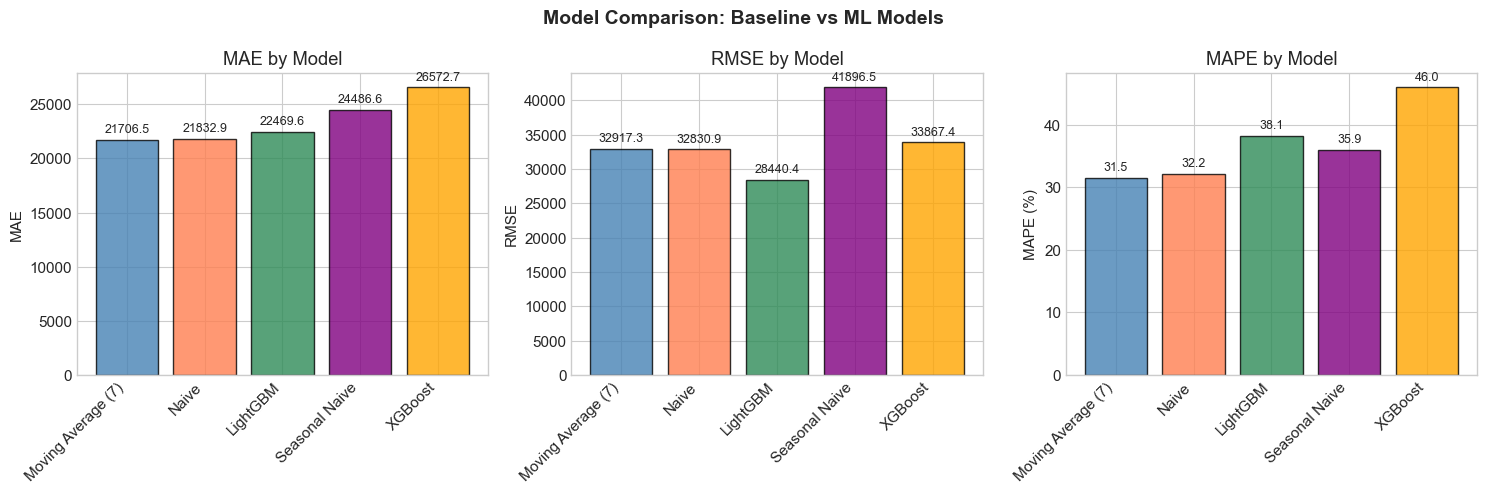

In [22]:
# Create comparison bar chart
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['MAE', 'RMSE', 'MAPE']
colors = ['steelblue', 'coral', 'seagreen', 'purple', 'orange']

for ax, metric in zip(axes, metrics):
    values = summary_df[metric].values
    models = summary_df.index.values
    
    bars = ax.bar(range(len(models)), values, color=colors[:len(models)], alpha=0.8, edgecolor='black')
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.set_ylabel(f'{metric}{" (%)" if metric == "MAPE" else ""}')
    ax.set_title(f'{metric} by Model')
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.annotate(f'{val:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.suptitle('Model Comparison: Baseline vs ML Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

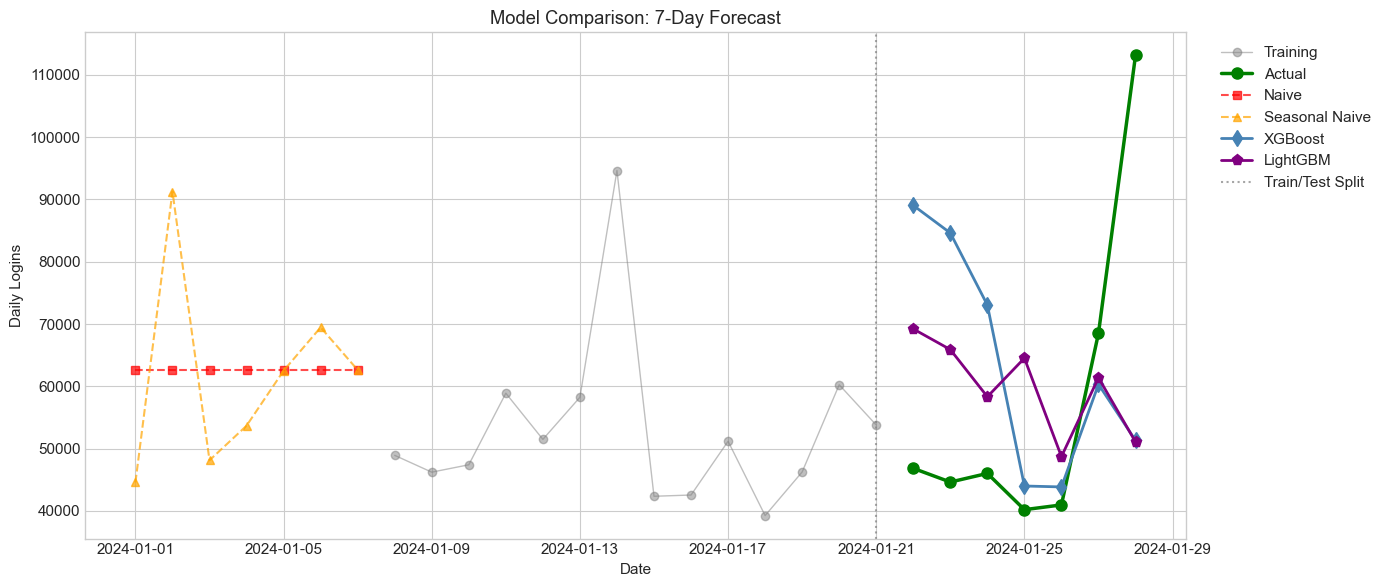

In [23]:
# Combined forecast visualization
fig, ax = plt.subplots(figsize=(14, 6))

# Training context
ax.plot(train_df['date'].iloc[-context_days:], train_df[TARGET].iloc[-context_days:], 
        'o-', color='gray', label='Training', alpha=0.5, linewidth=1)

# Actual values
ax.plot(valid_df['date'].iloc[:FORECAST_HORIZON], xgb_actuals, 
        'o-', color='green', label='Actual', linewidth=2.5, markersize=8)

# Predictions from each model
ax.plot(naive_results['dates'], naive_results['predictions'], 
        's--', color='red', label='Naive', linewidth=1.5, alpha=0.7)
ax.plot(seasonal_results['dates'], seasonal_results['predictions'], 
        '^--', color='orange', label='Seasonal Naive', linewidth=1.5, alpha=0.7)
ax.plot(xgb_predictions['date'], xgb_preds, 
        'd-', color='steelblue', label='XGBoost', linewidth=2, markersize=8)

if lgb_results is not None:
    ax.plot(lgb_results['predictions']['date'], lgb_results['preds'], 
            'p-', color='purple', label='LightGBM', linewidth=2, markersize=8)

ax.axvline(x=train_df['date'].iloc[-1], color='gray', linestyle=':', alpha=0.7, label='Train/Test Split')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Logins')
ax.set_title('Model Comparison: 7-Day Forecast')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

In [24]:
# Calculate improvement over best baseline
best_baseline_mae = min(naive_results['MAE'], seasonal_results['MAE'], ma_results['MAE'])
best_baseline_name = 'Seasonal Naive' if seasonal_results['MAE'] == best_baseline_mae else ('Naive' if naive_results['MAE'] == best_baseline_mae else 'Moving Average')

xgb_improvement = (best_baseline_mae - xgb_mae) / best_baseline_mae * 100

print("=" * 60)
print("IMPROVEMENT OVER BASELINE")
print("=" * 60)
print(f"\nBest Baseline Model: {best_baseline_name}")
print(f"Best Baseline MAE: {best_baseline_mae:.2f}")
print(f"\nXGBoost MAE: {xgb_mae:.2f}")
print(f"XGBoost Improvement: {xgb_improvement:+.1f}%")

if lgb_results is not None:
    lgb_improvement = (best_baseline_mae - lgb_results['mae']) / best_baseline_mae * 100
    print(f"\nLightGBM MAE: {lgb_results['mae']:.2f}")
    print(f"LightGBM Improvement: {lgb_improvement:+.1f}%")

IMPROVEMENT OVER BASELINE

Best Baseline Model: Moving Average
Best Baseline MAE: 21706.53

XGBoost MAE: 26572.68
XGBoost Improvement: -22.4%

LightGBM MAE: 22469.62
LightGBM Improvement: -3.5%


## 9. Summary and Discussion

### Key Findings

#### Model Performance

Based on our evaluation of baseline and ML models:

1. **XGBoost** and **LightGBM** leverage engineered features (temporal, lag, rolling) to capture complex patterns in the data.

2. **Feature importance** analysis reveals which features are most predictive:
   - Lag features (especially lag_7) typically rank highest due to strong weekly autocorrelation
   - Rolling mean features capture recent trends
   - Cyclical day-of-week features capture weekly seasonality

3. **Comparison with baselines** shows whether the added complexity of ML models is justified by improved accuracy.

#### When to Use ML Models

Tree-based models like XGBoost and LightGBM are particularly useful when:
- The time series has **complex, non-linear patterns**
- You have **external features** (holidays, events, promotions) that affect the target
- You need **feature importance** for interpretability
- The data has **outliers** or **non-stationary behavior**

#### Limitations

- **Recursive forecasting**: Multi-step predictions use recursive strategy, which can accumulate errors
- **Feature engineering**: Requires careful design of lag/rolling features
- **No uncertainty quantification**: Standard tree models don't provide prediction intervals

### Next Steps

1. **Hyperparameter tuning**: Use cross-validation to optimize model parameters
2. **Walk-forward validation**: Evaluate on multiple test windows for robust metrics
3. **Ensemble methods**: Combine XGBoost, LightGBM, and statistical models
4. **Feature selection**: Use importance scores to reduce feature set
5. **Add external regressors**: Holidays, events, weather data

In [25]:
# Save results for use in other notebooks
results_path = project_root / "data" / "processed" / "ml_model_results.csv"
results_path.parent.mkdir(parents=True, exist_ok=True)

final_summary = summary_df[['MAE', 'RMSE', 'MAPE', 'Avg_Rank']].copy()
final_summary.to_csv(results_path)
print(f"Results saved to {results_path}")

Results saved to c:\Users\juanlu\dev\volume-forecasting-poc\data\processed\ml_model_results.csv


---

**End of Notebook 06 - Machine Learning Models for Volume Forecasting**